#### Example getting, prepping and working with SDO/AIA data
Here using [sunpy](https://sunpy.org/) and [aiapy](https://pypi.org/project/aiapy/) with the other usual python packages. Working with the event featured in [Hannah & Kontar 2013 A&A](https://doi.org/10.1051/0004-6361/201219727).

* 21-Jan-2022 IGH

In [1]:
# Import some of the stuff we will need
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib
import scipy.io as io
import glob

import astropy.time as atime
from astropy.coordinates import SkyCoord
from astropy import units as u
import sunpy.map

from aiapy.calibrate import degradation
from aiapy.calibrate.util import get_correction_table
from aiapy.calibrate import register, update_pointing

import warnings
warnings.simplefilter('ignore')
plt.rcParams.update({'font.size': 16,'font.family':"sans-serif",\
                         'font.sans-serif':"Arial",'mathtext.default':"regular"})

In [2]:
fdir='/Users/iain/Desktop/aia_data/' 

---

In [3]:
# # Can either get the example data via fido/vso or adapt the example to your own AIA data set
# from sunpy.net import Fido, attrs as a

# # In this example only getting 94A (obviously for DEM calc would need more channels)
# wvsrch=a.Wavelength(94*u.angstrom)

# result = Fido.search(a.Time('2010-11-03T12:13:00', '2010-11-03T12:17:00'), a.Instrument("aia"), wvsrch)
# files = Fido.fetch(result,path='/Users/iain/Desktop/aia_data/')

In [4]:
# # Load in our AIA files for prep
# ff=sorted(glob.glob(fdir+'aia_lev1_94a_*.fits'))
# print(ff)

In [5]:
# # Load in the data
# amaps=sunpy.map.Map(ff)

In [6]:
# # Should be in chronological order as that was the order of ff
# # Useful to save out the time as might need them later
# atimes=[m.date for m in amaps]
# dtimes=[m.date.datetime for m in amaps]
# # for tt in times:
# #     print(tt.isot)
# print(atimes[0].mjd)

In [7]:
# # aiaprep the images, may take a while to run
# aprep=[]
# for m in amaps:
#     m_temp = update_pointing(m)
#     aprep.append(register(m_temp))

In [8]:
# # As the above steps are the slowest it might be useful to save up the prepd maps, 
# # so only need to run once, and them can load them in for next steps of analysis
# # 
# # Also we don't need the full map so can just save out the bits we need
# # ideally just a bit bigger than need as can always submap again
# blo=[-1150*u.arcsec,-500*u.arcsec]
# tro=[-850*u.arcsec,-200*u.arcsec]

# # Sunpy mapsequence could save these out as separate file but not great as need to make sequence then save out
# # As looping over each map to make submap, might as well just save the submap each time.

# for a in aprep:
#     bottom_left = SkyCoord(blo[0],blo[1], frame=a.coordinate_frame)
#     top_right = SkyCoord(tro[0],tro[1], frame=a.coordinate_frame)
#     stemp=a.submap(bottom_left=bottom_left, top_right=top_right)
#     amd=a.meta["date-obs"]
#     fname='aia_sub_'+str(a.meta["wavelnth"])+"_"+\
#         amd[0:4]+amd[5:7]+amd[8:10]+'_'+amd[11:13]+amd[14:16]+amd[17:19]+'.fits'
#     stemp.save(fdir+fname,overwrite='True')

---

In [9]:
# If you have run the above cell once then can just load the submaps back in 
# and don't have to get and prep the data
ffin=sorted(glob.glob(fdir+'aia_sub_94_*.fits'))
# nfls=len(ffin)
# print(ffin)
aprep=sunpy.map.Map(ffin)

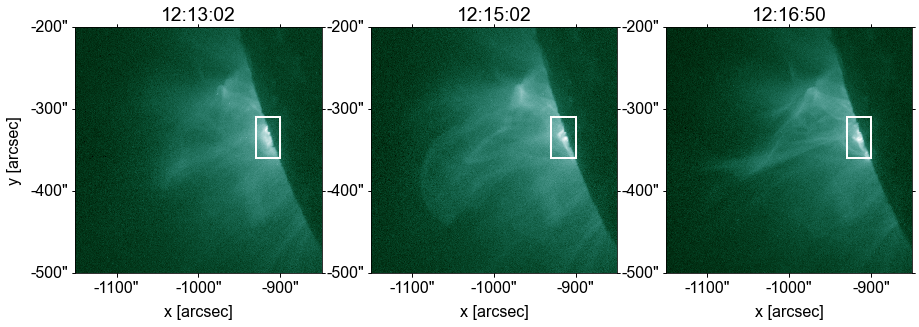

In [10]:
# check to see what they look like and pick region for more analysis

bbl=[-930 * u.arcsec, -360 * u.arcsec]
btr=[-900 * u.arcsec, -310 * u.arcsec]

fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 3, 1, projection=aprep[0])
aprep[0].plot(axes=ax1)
ax1.set_xlabel("x [arcsec]")
ax1.set_ylabel("y [arcsec]")
ax1.set_title(aprep[0].meta["date-obs"][11:19])
ax1.grid(False)
aprep[0].draw_quadrangle(SkyCoord(bbl[0],bbl[1], frame=aprep[0].coordinate_frame),\
                         top_right=SkyCoord(btr[0],btr[1], frame=aprep[0].coordinate_frame),\
                         edgecolor="white",lw=2)

ax2 = fig.add_subplot(1, 3, 2, projection=aprep[10])
aprep[10].plot(axes=ax2)
ax2.set_xlabel("x [arcsec]")
ax2.set_ylabel(" ")
ax2.set_title(aprep[10].meta["date-obs"][11:19])
ax2.grid(False)
aprep[10].draw_quadrangle(SkyCoord(bbl[0],bbl[1], frame=aprep[10].coordinate_frame),\
                         top_right=SkyCoord(btr[0],btr[1], frame=aprep[10].coordinate_frame),\
                         edgecolor="white",lw=2)

ax3 = fig.add_subplot(1, 3, 3, projection=aprep[19])
aprep[19].plot(axes=ax3)
ax3.set_xlabel("x [arcsec]")
ax3.set_ylabel(" ")
ax3.set_title(aprep[19].meta["date-obs"][11:19])
ax3.grid(False)
aprep[19].draw_quadrangle(SkyCoord(bbl[0],bbl[1], frame=aprep[19].coordinate_frame),\
                         top_right=SkyCoord(btr[0],btr[1], frame=aprep[19].coordinate_frame),\
                         edgecolor="white",lw=2)
plt.show()

In [11]:
# Let's loop over the subregion to find the mean DN/px 
data=[]
bbl=[-930 * u.arcsec, -360 * u.arcsec]
btr=[-900 * u.arcsec, -310 * u.arcsec]
for m in aprep:
    bottom_left = SkyCoord(bbl[0],bbl[1], frame=m.coordinate_frame)
    top_right = SkyCoord(btr[0],btr[1], frame=m.coordinate_frame)
    mm = m.submap(bottom_left=bottom_left, top_right=top_right)
    data.append(np.mean(m.data))
data=np.array(data)
print(data)

[15.6868344  15.70998873 15.62211773 15.74234863 16.02461251 16.28129421
 16.57343524 16.73541472 16.89367492 16.94962574 16.98277022 17.02949114
 17.13006394 17.20851035 17.28189067 17.31520038 17.40374282 17.45492599
 17.55130898 17.61110487]


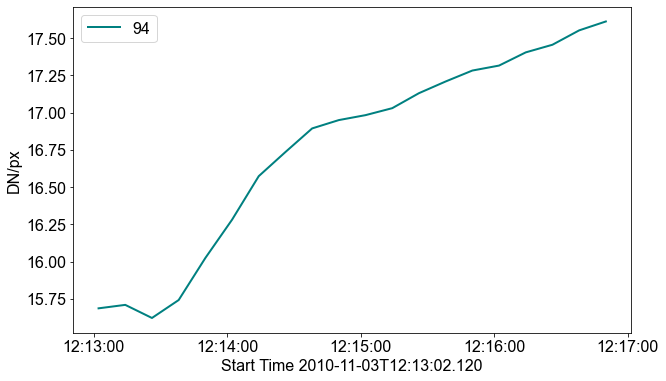

In [12]:
# Many ways of plotting data vs time in python (pandas, sunpy timeseries etc) here just using
# datetime with matplotlib
times=[m.date.datetime for m in aprep]
fig,ax = plt.subplots(figsize=(10, 6))
plt.plot(times,data,label="94",lw=2,color='teal')
ax.set_xlabel('Start Time '+aprep[0].date.isot)
ax.set_ylabel("DN/px")
# Need to tweak time labelling on the x-axis
myFmt = matplotlib.dates.DateFormatter('%H:%M:%S')
# majorx= matplotlib.dates.SecondLocator(interval=45)
majorx= matplotlib.dates.MinuteLocator(interval=1)
ax.xaxis.set_major_locator(majorx)
ax.xaxis.set_major_formatter(myFmt)
plt.legend()
plt.show()


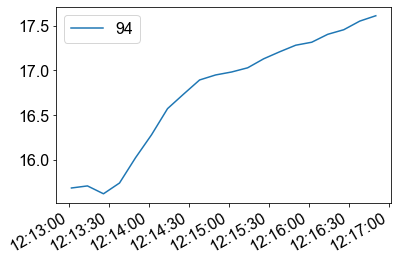

In [13]:
# Could also do this via pandas and sunpy timeseries
from sunpy.timeseries import TimeSeries
import pandas as pd
df = pd.DataFrame(data, index=times, columns=['94'])
header = {}
# Need astropy >v4.2 for units DN
units = {'intensity': u.DN/u.pixel}
ts = TimeSeries(df, header, units)
ts.peek() 

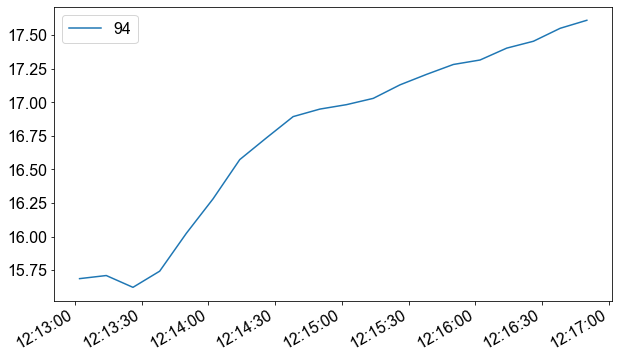

In [14]:
fig,ax = plt.subplots(figsize=(10, 6))
ts.plot()
plt.show()